In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, PReLU, Input, Reshape, Layer
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import numpy as np
from astropy.io import fits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter1d

def build_encoder(input_shape, latent_dim):
    input_layer = Input(shape=input_shape)

    # Convolutional Layers
    x = Conv1D(filters=128, kernel_size=5, padding='valid', name='conv1')(input_layer)
    x = PReLU(name='prelu1')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool1')(x)

    x = Conv1D(filters=256, kernel_size=11, padding='valid', name='conv2')(x)
    x = PReLU(name='prelu2')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool2')(x)

    x = Conv1D(filters=512, kernel_size=21, padding='valid', name='conv3')(x)
    x = PReLU(name='prelu3')(x)
    x = MaxPooling1D(pool_size=2, name='maxpool3')(x)

    # Flatten the output from Conv layers
    x = Flatten(name='flatten')(x)

    # Fully Connected Layers
    x = Dense(256, name='dense1')(x)
    x = PReLU(name='prelu4')(x)
    x = Dense(128, name='dense2')(x)
    x = PReLU(name='prelu5')(x)
    x = Dense(64, name='dense3')(x)
    x = PReLU(name='prelu6')(x)

    # Latent Space
    latent_space = Dense(latent_dim, name='latent_space')(x)

    return Model(input_layer, latent_space, name='encoder')

class ResampleLayer(Layer):
    def __init__(self, rest_frame_length, output_dim, min_observed_wavelength, max_observed_wavelength, **kwargs):
        super(ResampleLayer, self).__init__(**kwargs)
        self.rest_frame_length = rest_frame_length
        self.output_dim = output_dim
        self.min_observed_wavelength = min_observed_wavelength
        self.max_observed_wavelength = max_observed_wavelength

    def build(self, input_shape):
        super(ResampleLayer, self).build(input_shape)

    def call(self, inputs):
        x, z = inputs
        min_rest_wavelength = self.min_observed_wavelength / 2.2
        max_rest_wavelength = self.max_observed_wavelength / 1.5
        rest_frame_wavelength = tf.linspace(min_rest_wavelength, max_rest_wavelength, self.rest_frame_length)
        rest_frame_wavelength = tf.cast(rest_frame_wavelength, dtype=tf.float32)

        z = tf.cast(z, tf.float32)
        div = 1 + z

        min_observed_wavelength_div = tf.cast(self.min_observed_wavelength / div, dtype=tf.float32)
        max_observed_wavelength_div = tf.cast(self.max_observed_wavelength / div, dtype=tf.float32)

        start_index = tf.argmin(tf.abs(rest_frame_wavelength - min_observed_wavelength_div), axis=0)
        stop_index = tf.argmin(tf.abs(rest_frame_wavelength - max_observed_wavelength_div), axis=0)

        start_index = tf.cast(start_index, tf.int32)
        stop_index = tf.cast(stop_index, tf.int32)

        batch_size = tf.shape(x)[0]

        sections = []
        for i in range(batch_size):
            section = tf.slice(x[i], [start_index[i], 0], [stop_index[i] - start_index[i], -1])
            sections.append(section)
        sections = tf.stack(sections)

        interpolated = tf.image.resize(sections, [self.output_dim, 1])

        return tf.reshape(interpolated, [-1, self.output_dim, 1])

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim, 1)

def build_decoder(latent_dim, output_dim, z_min, z_max, min_observed_wavelength, max_observed_wavelength):
    latent_input = Input(shape=(latent_dim,))
    redshift_input = Input(shape=(1,))

    # Calculate rest frame wavelength range
    min_rest_wavelength = min_observed_wavelength / z_max
    max_rest_wavelength = max_observed_wavelength / z_min
    rest_frame_range = max_rest_wavelength - min_rest_wavelength

    # Calculate observed resolution
    observed_resolution = (max_observed_wavelength - min_observed_wavelength) / output_dim

    # Calculate rest frame length with twice the resolution
    rest_frame_length = int((rest_frame_range / observed_resolution) * 2)
    rest_frame_wavelength = tf.linspace(min_rest_wavelength, max_rest_wavelength, rest_frame_length)
    rest_frame_wavelength = tf.cast(rest_frame_wavelength, dtype=tf.float32)
    
    # Fully Connected Layers to generate rest frame representation
    x = Dense(64)(latent_input)
    x = PReLU()(x)
    x = Dense(256)(x)
    x = PReLU()(x)
    x = Dense(1024)(x)
    x = PReLU()(x)
    x = Dense(rest_frame_length)(x)
    x = Reshape((rest_frame_length, 1))(x)

    # Interpolate and resample
    def resample(args):
        x, z = args

        # Ensure z is of the correct type
        z = tf.cast(z, tf.float32)

        # Compute start and stop indices
        min_observed_wavelength_div = tf.cast(min_observed_wavelength / (1 + z), dtype=tf.float32)
        max_observed_wavelength_div = tf.cast(max_observed_wavelength / (1 + z), dtype=tf.float32)

        start_index = tf.argmin(tf.abs(rest_frame_wavelength - min_observed_wavelength_div))
        stop_index = tf.argmin(tf.abs(rest_frame_wavelength - max_observed_wavelength_div))

        # Ensure start_index and stop_index are of the correct type
        start_index = tf.cast(start_index, tf.int32)
        stop_index = tf.cast(stop_index, tf.int32)

        # Expand indices to match batch dimension
        start_index = tf.expand_dims(start_index, axis=0)
        stop_index = tf.expand_dims(stop_index, axis=0)

        # Use tf.slice with dynamic shapes
        batch_size = tf.shape(x)[0]
        batch_indices = tf.range(batch_size)
        batch_indices = tf.expand_dims(batch_indices, axis=-1)

        start_indices = tf.concat([batch_indices, start_index], axis=-1)
        stop_indices = tf.concat([batch_indices, stop_index], axis=-1)

        sections = []
        for i in range(batch_size):
            section = tf.slice(x[i], [start_indices[i][0], 0], [stop_indices[i][1] - start_indices[i][1], -1])
            sections.append(section)
        sections = tf.stack(sections)

        interpolated = tf.image.resize(sections, [output_dim, 1])

        return tf.reshape(interpolated, [-1, output_dim, 1])

    # Specify output_shape
    output = ResampleLayer(rest_frame_length, output_dim, min_observed_wavelength, max_observed_wavelength)([x, redshift_input])

    return Model([latent_input, redshift_input], output, name='decoder')

def build_autoencoder(input_shape, latent_dim, z_min, z_max, min_observed_wavelength, max_observed_wavelength):
    spectra_input = Input(shape=input_shape, name='spectra_input')
    redshift_input = Input(shape=(1,), name='redshift_input')

    encoder = build_encoder(input_shape, latent_dim)
    latent_space = encoder(spectra_input)
    
    decoder = build_decoder(latent_dim, input_shape[0], z_min, z_max, min_observed_wavelength, max_observed_wavelength)
    reconstructed_output = decoder([latent_space, redshift_input])

    return Model(inputs=[spectra_input, redshift_input], outputs=reconstructed_output, name='autoencoder')

In [2]:
data_dir = '/Users/tkiker/Documents/GitHub/AGN-UMAP/data/sdss_spectra'

file_names = []
spectra = []
zs = []

x = np.linspace(3550, 10400, 4500)

for file_name in os.listdir(data_dir)[0:64]:
    hdul = fits.open(os.path.join(data_dir, file_name))
    
    data = hdul[1].data

    wavelength = 10**data["loglam"]
    flux = data["flux"]

    flux = gaussian_filter1d(flux, sigma=3)
    flux = np.interp(x, wavelength, flux)

    z = hdul[2].data['z'][0]

    rest_wavelength = x/(1+z)

    norm_mask = np.logical_and(rest_wavelength>=2000, rest_wavelength<=2500)
    flux /= np.median(flux[norm_mask])

    spectra.append(flux)
    file_names.append(file_name)
    zs.append(z)

spectra = np.array(spectra)
zs = np.array(zs)

# Reshape spectra data to match the expected input shape
spectra = np.expand_dims(spectra, axis=-1)

X_train_spectra, X_val_spectra, X_train_zs, X_val_zs = train_test_split(spectra, zs, test_size=0.2, random_state=42)
X_train = [X_train_spectra, X_train_zs]
X_val = [X_val_spectra, X_val_zs]

print(np.min(x), np.max(x))

3550.0 10400.0


In [5]:
autoencoder = build_autoencoder(input_shape=(len(x), 1), latent_dim=10, z_min=1.5, z_max=2.2,
                                min_observed_wavelength=np.min(x),
                                max_observed_wavelength=np.max(x))

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Train the autoencoder
history = autoencoder.fit(X_train, X_train_spectra, epochs=1, batch_size=4, validation_data=(X_val, X_val_spectra))

# Save the training history
history_dict = history.history

ValueError: Exception encountered when calling ResampleLayer.call().

[1mCannot convert '4500' to a shape.[0m

Arguments received by ResampleLayer.call():
  • args=(['<KerasTensor shape=(None, 6989, 1), dtype=float32, sparse=False, name=keras_tensor_59>', '<KerasTensor shape=(None, 1), dtype=float32, sparse=None, name=keras_tensor_51>'],)
  • kwargs=<class 'inspect._empty'>

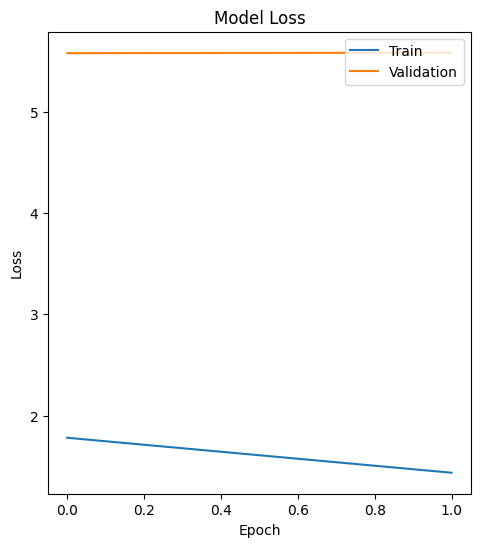

In [6]:
# Plot the training history
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Show the plots
plt.show()